# Detección de marca de agua

>[Detección de marca de agua](#scrollTo=gnsig08lPC7h)

>>[Introducción](#scrollTo=tw4FPO7FPobI)

>>[Planteamiento teórico](#scrollTo=Ciu4qGLaVFzM)

>>>[Incrustación de la marca de agua](#scrollTo=P7h6_-fZWsa5)

>>>[Preprocesamiento de la Imagen con Marca de Agua](#scrollTo=0fqlrvifZvie)

>>>>[Variación Total (TV-L1)](#scrollTo=tLfSdpKvahYE)

>>>[Detección de bordes](#scrollTo=rLqV3YpQlLtb)

>>>>[Canny](#scrollTo=YKXunaUxlW-9)

>>>[Clasificación de Bordes](#scrollTo=rJLiRlyXqUtm)

>>>>[Otsu](#scrollTo=ctO3te-G0Zpv)

>>>>[Discriminación de los bordes](#scrollTo=zTFfi_De3s4J)

>>[Implementación](#scrollTo=P4EDQ5AN8Jiu)

>>[Experimentación](#scrollTo=0FQ4Cjw8xE_q)

>>>[Encontrar los mejores valores](#scrollTo=X1S3f3rMyZXk)

>>>[Análisis distintos parámetros](#scrollTo=AYF0HhUD9BIN)

>>>>[Imágenes lisas](#scrollTo=2Hw51bVM_XG0)

>>>>[Patrones](#scrollTo=VfUAXsKSTey4)

>>>>[Detalladas](#scrollTo=CPkbT24yaeUk)

>>[Conclusión](#scrollTo=7K-EuYrAkkMA)

>[Autoevaluación](#scrollTo=7L_o_7hEvPwq)

>[Bibliografía](#scrollTo=_Y6sPQqCp3ba)



## Introducción

En el ámbito de la propiedad intelectual de imágenes, la presencia de marcas de agua es una preocupación común. Hoy en día, es habitual encontrar imágenes en línea que presentan marcas de agua visibles. Para abordar este desafío, se han desarrollado diversas técnicas para eliminar estas marcas. Sin embargo, muchas de estas estrategias requieren un proceso manual de detección de la marca de agua antes de poder eliminarla, lo cual puede resultar laborioso y poco eficiente.

En este trabajo, nos proponemos aplicar el método de detección de marcas de agua propuesto en el artículo [An Automatic Visible Watermark Detection Method using Total Variation](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7935109) y evaluar su eficacia en diversos tipos de imágenes y con distintas marcas de agua. A través de estos análisis, buscamos mejorar la eficiencia del proceso de detección y eliminación de marcas de agua en imágenes. Este avance puede resultar útil para mejorar la estética de las imágenes, facilitar su reutilización y modificación, mantener la coherencia visual, recuperar imágenes valiosas y proteger la privacidad en distintos contextos.

## Planteamiento teórico

La celda de abajo carga las dependencias necesarias para trabajar con el notebook completo.

In [ ]:
# Conectarse a drive
from google.colab import drive
drive.mount('/content/drive')
base_path = '/content/drive/MyDrive/Watermark - Notebooks/'

In [ ]:
# Import dependencies
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, img_as_float, util
from skimage.restoration import denoise_tv_chambolle
import os  # Para manejar rutas de directorios

Mounted at /content/drive


### Incrustación de la marca de agua

**¿Qué es una Marca de Agua?**

Una marca de agua es un patrón transparente o semitransparente que se coloca sobre una imagen, documento o cualquier otro tipo de contenido digital con el fin de identificar su origen o propiedad. Esta marca puede consistir en texto, logotipos, imágenes o cualquier combinación de estos elementos. Por lo general, se utiliza para fines de derechos de autor o para proteger la propiedad intelectual de una obra digital, como fotografías, documentos PDF, vídeos o música. La marca de agua suele ser sutil para no interferir demasiado con la visualización del contenido, pero lo suficientemente visible como para disuadir la copia no autorizada o el uso indebido.

Las marcas de agua visibles deben cumplir ciertos requisitos, de los cuales, los principales son:

1. Deben ser completamente visible para proteger los derechos de propiedad del autor.

2. No deben ser obstrusivas, garantizando que la imagen original se vea.

Para satisfacer estos requisitos, la intensidad del patrón de la marca de agua debe ser calculada de forma que se adapte a las características de la imagen original. De forma genérica, la composición de la marca de agua está dada por la siguiente expresión:

\begin{align}
  X(p) = α(p)W(p) + (1-α(p))Y(p)
\end{align}

donde $p=(i,j)$ representa la localización del pixel en la imagen, $α(p)$ es la opacidad variable, $W(p)$ es la marca de agua, e $Y(p)$ es la imagen original. Las marcas de agua más usadas son translúcidas para mantener el contenido de la imagen subyacente parcialmente visible, lo que significa que $α(p)$ está en el intervalo de $[0,1]$ para todos los píxeles.

In [ ]:
# @title Añadir la marca de agua

def combine_images(image_path1, image_path2, alpha):
    # Cargar las imágenes
    img1 = cv2.imread(image_path1)
    img2 = cv2.imread(image_path2)

    # Calcular beta
    beta = 1 - alpha

    # Asegurarse de que ambas imágenes estén cargadas correctamente
    if img1 is None or img2 is None:
        print("Error al cargar las imágenes. Asegúrate de que las rutas sean correctas.")
        return None

    # Determinar el tamaño mínimo compartido
    height = min(img1.shape[0], img2.shape[0])
    width = min(img1.shape[1], img2.shape[1])

    # Redimensionar imágenes al tamaño mínimo compartido
    img1 = cv2.resize(img1, (width, height))
    img2 = cv2.resize(img2, (width, height))

    # Combinar las imágenes
    combined_image = cv2.addWeighted(img1, alpha, img2, beta, 0)

    # Convertir de BGR a RGB
    combined_image = cv2.cvtColor(combined_image, cv2.COLOR_BGR2RGB)

    # Guardar la imagen combinada en la carpeta marcadas como marcada
    save_path = os.path.join(base_path + 'Images/marcadas', 'marcada.png')
    cv2.imwrite(save_path, combined_image)
    # Guarda la marca de agua en la carpeta marcada como marcaUsada
    save_path = os.path.join(base_path + 'Images/marcadas', 'marcaUsada.png')
    cv2.imwrite(save_path, img1)
    # Mostrar la imagen combinada
    plt.imshow(combined_image)
    plt.axis('off')  # Ocultar los ejes
    plt.show()

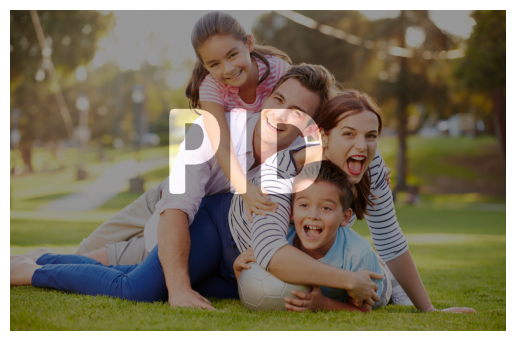

In [ ]:
# Ejecutar código
combine_images(base_path + 'Images/marcas_de_agua/PID.png', base_path + 'Images/familia.jpg', 0.4)

### Preprocesamiento de la Imagen con Marca de Agua

En primer lugar, someteremos la **imagen con marca de agua** $I^W$ a un preprocesamiento del que se obtendrá, por un lado, la **imagen estructural** $I^c$, y por otro, la **imagen de texturas** $I^t$, todo esto, aplicando el modelo TV-L1.

Para la detección de la marca de agua nos centraremos en la imagen estructura $I^c$, que se obtiene mediante la siguiente expresión.

\begin{align}
  I^c = TV^{L1}(I^W)
\end{align}

#### Variación Total (TV-L1)

La **variación total** (Total variation, TV) es un medidor de la complejidad de una imagen respecto una variación espacial, por lo tanto una señal con exceso de detalles tiene una variación total alta. Esta es la formula de la variación total:

\begin{equation*}
TV(X)=\sum_{i,j\in\mathcal{N}} \|x_i-x_j\|_p^q
\end{equation*}
𝒩 define los pixeles vecinos y *x* los pixeles tridimensionales (RGB) de la imagen.

Reduciendo la variación total de la señal eliminamos los detalles no deseadoos a la vez que conservamos los detalles importantes de la señal como los **bordes**.

El suavizado mediante este método se hace con el siguiente método de optimización:
\begin{align}
\min_X\quad \|X-Y\|^2+\lambda TV(X)
\end{align}

λ es un termino positico de reguralización (peso) e *Y* es la imagen que queremos suavizar.

> **La optimización encuentra la imagen *X* que coincide con la imagen Y pero tiene una variación total limitada/mínima.**


En nuestro caso vamos a usar la **TV-L1**, por lo que *(p=1, q=1)*. Por lo tanto, en TV-L1 se sumará la diferencia absoluta de cada componente de color independientemente.
\begin{align*}
TV_{ℓ^1}(X) = \sum_{i,j \in N} \sum_{k} \|x_{i, k} - x_{j, k}\|_{1}
\end{align*}
xₖ son los pixeles de cada componente de color (RGB)

Para asentar toda la información previa, el problema de optimzación para suavizar la images sería:
\begin{align}
\min_X\quad \|X-Y\|^2+\lambda (\sum_{i,j \in N} \sum_{k} \|x_{i, k} - x_{j, k}\|_{1})
\end{align}

In [ ]:
# @title Suavizado TV-L1

def TVL1(image_path):
  # Carga imagen
  image_w = cv2.imread(base_path + image_path)

  # Pasar la imagen a números reales
  image_float = img_as_float(image_w)

  # Aplicar el filtro TV-L1 para reducir la Variación Total
  tv_denoised_image = denoise_tv_chambolle(image_float, weight=0.5, multichannel=True)

  # Pasar la imagen a 8-Bytes
  tv_denoised_image = util.img_as_ubyte(tv_denoised_image)

  # Path to store the denoised image
  cv2.imwrite(base_path + 'Images/image_denoised.png', tv_denoised_image)

  # Mostrar la imagen original y la suavizada
  plt.figure(figsize=(12, 6))
  plt.subplot(121), plt.imshow(image_w), plt.title('Imagen Original'), plt.axis('off')
  plt.subplot(122), plt.imshow(tv_denoised_image), plt.title('Imagen con Filtro de TV'), plt.axis('off')
  plt.show()

<ipython-input-100-3bb378c255b0>:11: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  tv_denoised_image = denoise_tv_chambolle(image_float, weight=0.5, multichannel=True)


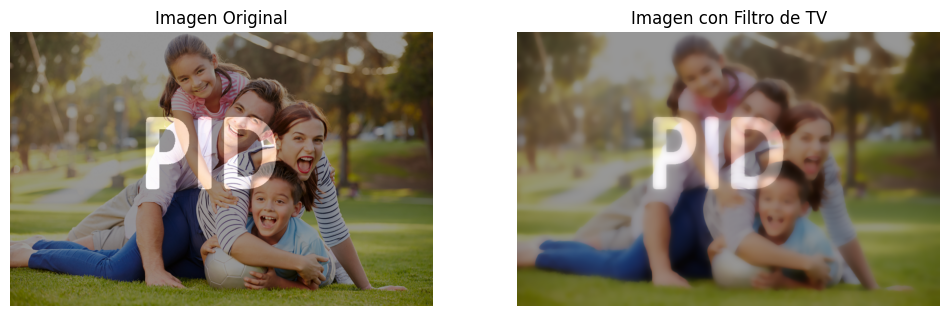

In [ ]:
# Ejecutar código
TVL1('Images/marcadas/marcada.png')

### Detección de bordes

Una vez eliminados los detalles inecesarios de la imagen obtenemos los bordes de la imagen estructural $I^c$. Estos se obtienen por el operador de bordes Canny de la forma

\begin{align}
  I^e = canny(I^c)
\end{align}

donde, $I^e$ es la imagen binaria resultante en la que los píxeles pertenecientes a un borde toman valor 1, y los píxeles pertenecientes al fondo toman valor 0.

#### Canny

El algoritmo de detección de bordes de Canny consta de varios pasos:
1. **Reducción de ruido**: Antes de detectar los bordes, la imagen se suaviza utilizando un filtro gaussiano para reducir el ruido presente en la imagen.

2. **Cálculo de gradiente de intensidad**: Se calcula el gradiente de intensidad de la imagen suavizada utilizando operadores de derivada, operador Sobel, en las direcciones horizontal y vertical. Esto ayuda a resaltar las regiones de la imagen donde hay un cambio brusco en la intensidad, lo que suele indicar la presencia de un borde.

3. **Supresión de no máximos**: Se examinan los píxeles en la dirección del gradiente y se conservan solo aquellos que tienen una intensidad máxima en esa dirección (máximos locales). Esto ayuda a refinar la detección de bordes y a obtener bordes más delgados y precisos.

4. **Doble umbralización**: Finalmente, se aplican dos umbrales, uno bajo y otro alto, para determinar qué píxeles se considerarán como parte de un borde. Los píxeles con intensidades por encima del umbral alto se consideran píxeles de borde fuertes, mientras que aquellos entre los umbrales bajo y alto se consideran píxeles de borde débiles. Los píxeles por debajo del umbral bajo se descartan. Además, se realiza una operación de conexión para mantener solo los bordes continuos y eliminar los bordes cortos o fragmentados.

In [ ]:
# @title Detectar bordes

def canny():
  # Cargar imagen suavizada
  image_denoised = cv2.imread(base_path + 'Images/image_denoised.png')

  # Aplicar Canny para extraer los bordes de la imagen
  image_edges = cv2.Canny(image_denoised, 50, 100)

  # Guardar la imagen de los bordes
  cv2.imwrite(base_path + 'Images/image_edges.png', image_edges)

  plt.figure(figsize=(16,6))
  plt.subplot(121), plt.title('Imagen Suavizada'), plt.imshow(image_denoised, cmap='gray'), plt.axis('off')
  plt.subplot(122), plt.title('Bordes de la Imagen'), plt.imshow(image_edges, cmap='gray'), plt.axis('off')
  plt.show()

Podemos observar en el resultado que no se marcan todos los bordes de la imagen porque se han eliminado los detalles innecesarios de la imagen en el preprocesado y solo marca las secciones de la imagen mas importantes como es ma marca de agua y el borde exterior de la familia.

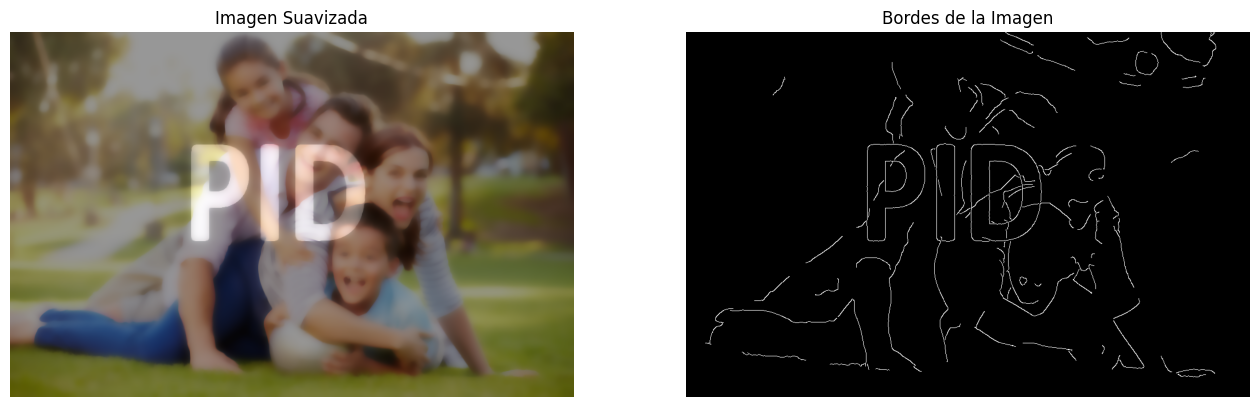

In [ ]:
## Ejecutar código
canny()

### Clasificación de Bordes

Una vez que hemos obtenido los bordes de la imagen, utilizaremos el método de umbralización de Otsu para conservar únicamente aquellos bordes que pertenecen a la marca de agua.Para ello, dividimos la imagen estructural $I^e$(imagen preprocesada) en $B$ bloques de tamaño $k \times k$ centrados en la posición $(i,j)$, donde $I^e(i,j)=1$. Cada bloque estará centrado en un pixel que en el paso anterior se ha establecido como borde. A estos bloques se le calcularia el Umbral con Otsu: $T_b = Thresholding(B_b)$


Para calcular la diferencia entre los bordes, calculamos la media $μ^q_b$ de los valores de los píxeles del bloques que son mayores o igual que el umbral calculado ($T_b$), así como la media $μ^0_b$ de los valores de los píxeles del bloque que son menores que $T_b$..

Definimos la diferencia de los bordes en el bloque $B_b$: $\rho_{b} = \mu_{b}^{q}-\mu_{b}^{o}$.

> $k$ es un valor establecido por el usuario.


#### Otsu



El método de Otsu es una técnica de umbralización automática utilizada para separar los niveles de gris de una imagen en dos clases:
- uno que representa el objeto de interés.
- otro que representa el fondo.

El objetivo es encontrar el umbral óptimo que maximiza la varianza entre las dos clases. Se siguen los siguientes pasos:
1. **Histograma de la imagen**: Se calcula el histograma de la imagen, que es una representación de la distribución de los niveles de gris en la imagen. El histograma muestra la frecuencia de aparición de cada valor de intensidad de píxel en la imagen.

2. **Calculo de probabilidades de ocurrencia**: A partir del histograma, se calculan las probabilidades de ocurrencia de cada nivel de gris en la imagen.Dividimos el número de píxeles de cada nivel de gris por el número total de píxeles en la imagen.

3. **Calculo de medias de intensidad**: Se calculan las medias de intensidad ponderadas para cada nivel de gris, la suma de la intensidad de píxeles multiplicada por su probabilidad de ocurrencia.

4. **Varianza entre clases**: La varianza entre clases mide la homogeneidad entre las dos clases separadas por el umbral. Se calcula como la suma ponderada de las varianzas de las dos clases.

5. **Selección del umbral óptimo**: El método de Otsu busca el umbral que maximiza la varianza entre clases. Esto se logra al iterar sobre todos los posibles umbrales y seleccionar aquel que produce la mayor varianza entre las clases.


#### Discriminación de los bordes


Finalmente para determinar si el pixel del borde pertenece o no a la marca de agua, lo clasificamos de la siguiente manera:
\begin{equation*} \text{if}\ \begin{cases} d-r\leq\rho_{b}\leq d+r & \text{Pertenece a la Marca de agua}\\ \text{en otro caso} & \text{NO pertenece a la Marca de agua} \end{cases} \end{equation*}

Donde $d$ es la distancia entre los umbrales de los bloques y $r$ el rango de tolerancia de la clasificación.
> $d$ y $r$ son valores establecido por el usuario.

Finalmente solo conservamos los pixeles de los bordes que cumplan la condición anterior.

In [ ]:
# @title Clasificación de bordes

def edges_classification(k,d,r):
    # Cargar imagen de los bordes
    edges = cv2.imread(base_path + 'Images/image_edges.png')
    edges = cv2.cvtColor(edges, cv2.COLOR_RGB2GRAY)

    # Cargar imagen structural
    structural_image = cv2.imread(base_path + 'Images/image_denoised.png')
    structural_image = cv2.cvtColor(structural_image, cv2.COLOR_RGB2GRAY)

    # Inicializamos el output para guardar la imagen con los bordes de la marca de agua
    watermark_edges = np.zeros_like(structural_image)

    # Dividir la imagen en kxk bloques y procesar
    rows, cols = edges.shape
    for i in range(rows):
        for j in range(cols):
          if edges[i,j] > 0:
            block = structural_image[max(i-k//2,0):min(i+k//2,rows), max(j-k//2,0):min(j+k//2,cols)]
            # Aplicamos Otsu para encontra el umbral óptimo del bloque
            threshold, _ = cv2.threshold(
                  block,
                  0,
                  255,
                  cv2.THRESH_BINARY + cv2.THRESH_OTSU
            )
            # Calcualr el valor medioa por encima y por debajo del umbral
            pixels_above = block[block >= threshold]
            pixels_below = block[block < threshold]
            qPb = np.mean(pixels_above) if pixels_above.size > 0 else 0
            oPb = np.mean(pixels_below) if pixels_below.size > 0 else 0

            # Computar la diferencia de las medias
            Ub = np.abs(qPb - oPb)

            # Casoficar los bordes en base a Ub, d y r
            if d-r <= Ub and Ub <= d+r:
              watermark_edges[i,j] = 255

    cv2.imwrite(base_path + 'Images/watermark_edges.png',watermark_edges)

    plt.figure(figsize=(16,6))
    plt.subplot(121), plt.title('Imagen de bordes'), plt.imshow(edges, cmap='gray'), plt.axis('off')
    plt.subplot(122), plt.title('Bordes de la marca de agua'), plt.imshow(watermark_edges, cmap='gray'), plt.axis('off')
    plt.show()

Observamos que que mayor parte de los bordes que no pertenecian a la marca de agua se han eliminado y podemos ver claramente la forma de la marca de agua que incrustamos al inicio en la imagen.

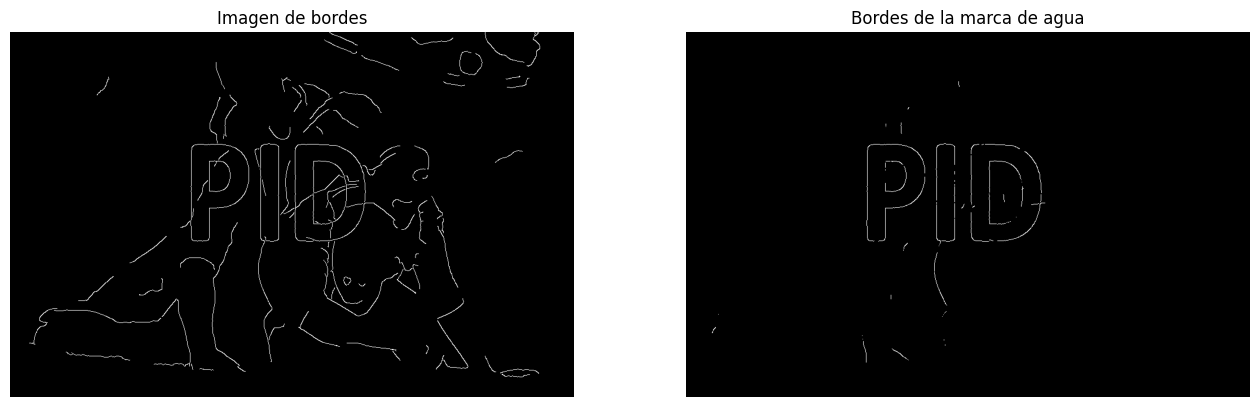

In [ ]:
# Ejecutar código

edges_classification(5, 50,20)

## Implementación

Con el objetivo de simplificar y optimizar el proceso, hemos integrado todo el método en una única función. Ahora, al ingresar una imagen con marca de agua, el sistema proporciona directamente la clasificación correspondiente.

In [ ]:
# @title Detección automática de Marca de agua
def detect_and_classify_watermark(image_path, k, d, r, tv_weight=0.5, store=''):
  """
  This function loads every needed method to process and manipulate the
  image with watermark.

  Parameters
  ----------
  image_path: str
    access path to host image
  k: int
  d: int
  r: int
  tv_weight: float
  store: string
    if store then every image of the process will be stored at store path

  Returns
  -------
  np.array: watermark mask of the image host.
  """

  def preprocess_image(image):
    """
    Preprocessing host image to reduce details keeping edges. This method
    implements TV-L1 denoising algorithm.
    """
    image_float = img_as_float(image)

    # # Apply TV filter to reduce the Total Variation with L1
    structural_image = denoise_tv_chambolle(image_float, weight=tv_weight, multichannel=True)

    # # Convert the image into the appropiated type
    structural_image = util.img_as_ubyte(structural_image)

    if store:
      cv2.imwrite(
        store + 'structural_image.png',
        structural_image
      )

    return structural_image

  def edge_detection_and_classification(structural_image):
    """
    Calculates edges of denoised image and classifies them by otsu algoritm.
    """
    # Apply Canny edge detection
    image_edges = cv2.Canny(structural_image, 50, 100)

    if store:
      cv2.imwrite(
        store + 'canny_image.png',
        image_edges
      )

    structural_image = cv2.cvtColor(structural_image, cv2.COLOR_RGB2GRAY)

    # Initialize output image for watermark edges
    watermark_edges = np.zeros_like(structural_image)

    # Divide image into k x k blocks and process
    rows, cols = image_edges.shape
    cont = 0
    for i in range(rows):
      for j in range(cols):
        if image_edges[i,j] > 0:
          block = structural_image[max(i-k//2,0):min(i+k//2,rows), max(j-k//2,0):min(j+k//2,cols)]

          # if store and cont < 50:
          #   cont += 1
          #   cv2.imwrite(
          #     store + f"bloques/bloque({i},{j}).png",
          #     block
          #   )

          # Apply Otsu's thresholding to find optimal threshold for the block
          threshold, _ = cv2.threshold(
              block,
              0,
              255,
              cv2.THRESH_BINARY + cv2.THRESH_OTSU
            )

          # Calculate mean values above and below the threshold
          pixels_above = block[block >= threshold]
          pixels_below = block[block < threshold]
          qPb = np.mean(pixels_above) if pixels_above.size > 0 else 0
          oPb = np.mean(pixels_below) if pixels_below.size > 0 else 0

          # Compute edge difference
          Ub = np.abs(qPb - oPb)

          # Classify edges based on Ub, d, and r
          if d-r <= Ub and Ub <= d+r:
              watermark_edges[i,j] = 255

    if store:
      cv2.imwrite(
        store + 'watermark_edges.png',
        watermark_edges
      )

    return watermark_edges


  # Load image in grayscale
  try:
    image_with_watermark = cv2.imread(image_path)
    if image_with_watermark is None:
      raise ValueError('Error: Image not found.')
  except:
    return None

  structural_image = preprocess_image(image_with_watermark)
  watermark_edges = edge_detection_and_classification(structural_image)

  return watermark_edges

<ipython-input-71-788b1d9e3aa7>:31: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  structural_image = denoise_tv_chambolle(image_float, weight=tv_weight, multichannel=True)


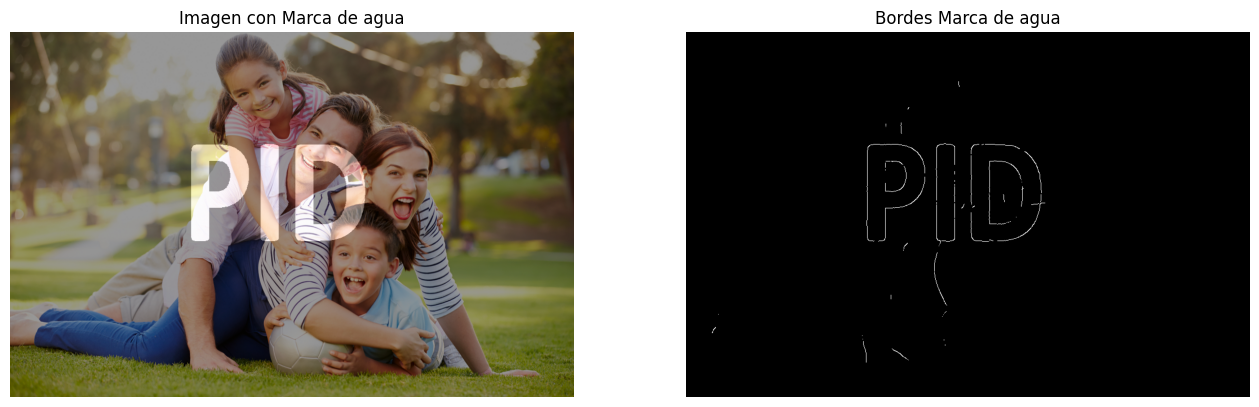

In [ ]:
# Ejecutar código

watermark_edges = detect_and_classify_watermark(base_path + 'Images/marcadas/marcada.png', 5, 50,20)

image_watermarket = cv2.imread(base_path + 'Images/marcadas/marcada.png')

plt.figure(figsize=(16,6))
plt.subplot(121), plt.title('Imagen con Marca de agua'), plt.imshow(image_watermarket, cmap='gray'), plt.axis('off')
plt.subplot(122), plt.title('Bordes Marca de agua'), plt.imshow(watermark_edges, cmap='gray'), plt.axis('off')
plt.show()

## Experimentación

Dado que la discriminación de los bordes que no forman parte de la marca de agua está condicionada por los valores $k$, $d$ y $r$, los cuales son introducidos por el usuario, hemos llevado a cabo diversas pruebas para determinar qué combinación de valores optimiza el rendimiento en distintos tipos de imágenes. Además, hemos investigado cómo estas variables se relacionan con el porcentaje de error al clasificar si un borde pertenece o no a la marca de agua.

 ### Encontrar los mejores valores

Inicialmente, hemos desarrollado un código que explora diversas combinaciones de las variables $k$, $d$ y $r$. Este código evalúa qué píxeles ha identificado correctamente como parte de la marca de agua y cuáles ha marcado erróneamente. Al finalizar la iteración, obtenemos las variables que ofrecen el mejor rendimiento para esa imagen en particular.

In [ ]:
# @title Encontrar los mejores parámetros

def find_best_parameters(image_watermarket_path, watermark_path):
  image_marca_agua = cv2.imread(base_path + watermark_path, cv2.IMREAD_GRAYSCALE)
  image_edges_marca = cv2.Canny(image_marca_agua, 50, 100)

  # Inicializa un diccionario para guardar el número de píxeles no comunes para cada configuración
  non_common_pixels_dict = {}

  # Procesa las imágenes para diferentes combinaciones de k, d, y r
  for k in range(5, 66, 15):
      for d in range(26, 106, 10):
          for r in range(10, 31, 5):
              image_path = base_path + image_watermarket_path
              watermark_edges = detect_and_classify_watermark(image_path, k, d, r, 0.5,base_path + 'Images/proceso/')
              output_path = base_path + 'Images/proceso/' + f"test_{k}_{d}_{r}.png"
              cv2.imwrite(output_path, watermark_edges)

              # Realiza la operación XOR para encontrar píxeles no comunes
              non_common_pixels = cv2.bitwise_xor(watermark_edges, image_edges_marca)
              number_of_non_common_pixels = np.sum(non_common_pixels == 255)

              # Guarda el número de píxeles no comunes en el diccionario usando una tupla (k, d, r) como clave
              non_common_pixels_dict[(k, d, r)] = number_of_non_common_pixels
              #print(f'Número de píxeles que no son comunes para k={k}, d={d}, r={r}: {number_of_non_common_pixels}')

  # Encuentra la combinación de (k, d, r) que minimiza el número de píxeles no comunes
  min_config = min(non_common_pixels_dict, key=non_common_pixels_dict.get)
  print('La configuración que minimiza el número de píxeles no comunes es:', min_config)

  # Muestra la última imagen procesada
  best_image_path = base_path + 'Images/proceso/' + f"test_{min_config[0]}_{min_config[1]}_{min_config[2]}.png"
  best_image = cv2.imread(best_image_path, cv2.IMREAD_GRAYSCALE)
  if best_image is not None:
      plt.figure(figsize=(10, 10))
      plt.imshow(best_image, cmap='gray')
      plt.title(f'Mejor imagen con k={min_config[0]}, d={min_config[1]}, r={min_config[2]} - Numero de píxeles erroneos: {non_common_pixels_dict[(min_config[0], min_config[1], min_config[2])]}')
      plt.show()
  else:
      print("Error: No se pudo cargar la mejor imagen.")

A pesar de que la detección no es perfecta y aún se detectan algunos píxeles incorrectos, es evidente que el contorno de la marca de agua está prácticamente definido en su totalidad. Tras evaluar 225 combinaciones, podemos afirmar con seguridad que esta configuración es la más adecuada para esta imagen.

<ipython-input-71-788b1d9e3aa7>:31: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  structural_image = denoise_tv_chambolle(image_float, weight=tv_weight, multichannel=True)


La configuración que minimiza el número de píxeles no comunes es: (5, 56, 25)


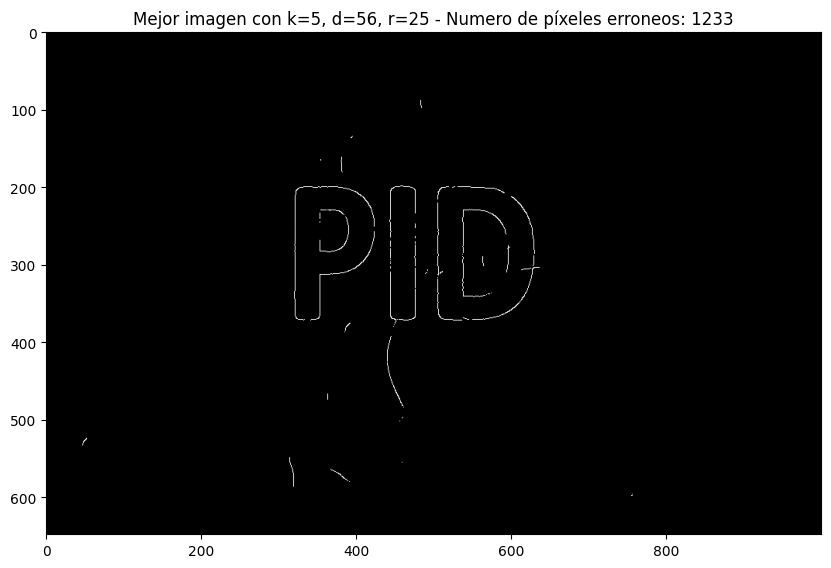

In [ ]:
# Ejecutar código (esta función tarda 30min en ejecutarse)
find_best_parameters('Images/marcadas/marcada.png', 'Images/marcadas/marcaUsada.png')

### Análisis distintos parámetros

Después de desarrollar el código para encontrar los parámetros que reducen al mínimo el error de píxeles, procedimos a probar este algoritmo en múltiples imágenes de diversos tipos. Nos enfocamos en tres categorías principales de imágenes:

* Imágenes **lisas**, que tienen pocos detalles.


* Imágenes con **patrones** definidos.

* Imágenes **detalladas**, con una gran cantidad de elementos.

Además probamos 3 tipos de marcas de agua:
* Tipo letra (Figura 1)
* Forma. (Figura 2)
* Multiples marcas alineadas. (Figura 3)

Nuestra meta es identificar parámetros comunes para estas categorías de imágenes, con el fin de obtener los mejores resultados al aplicar el algoritmo de detección.


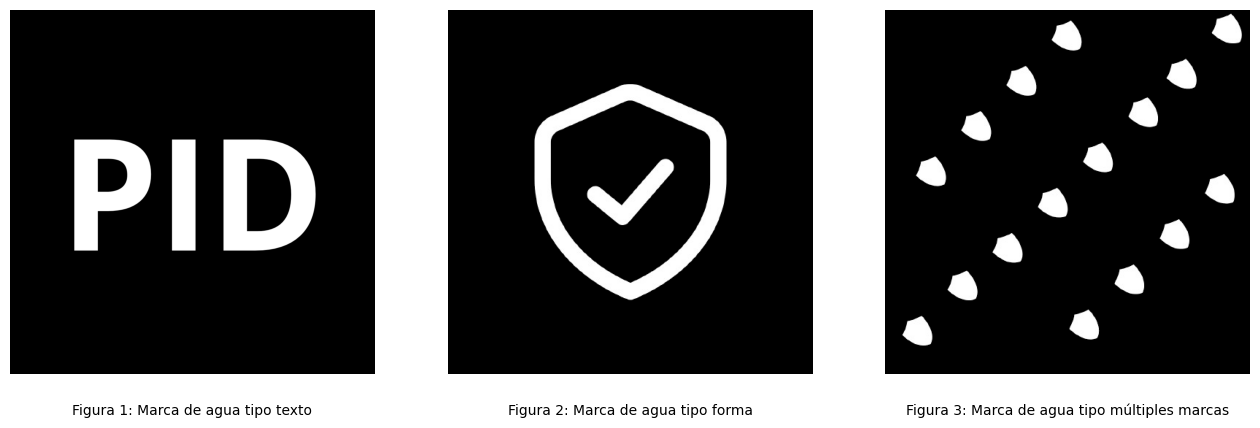

In [ ]:
# @title Marcas de agua usadas

watermark_PID = cv2.imread(base_path + 'Images/marcas_de_agua/6.png')
watermark_escudo = cv2.imread(base_path + 'Images/marcas_de_agua/escudo.png')
watermark_multiescudo = cv2.imread(base_path + 'Images/marcas_de_agua/multiple_escudo.png')

plt.figure(figsize=(16,6))

plt.subplot(131)
plt.imshow(watermark_PID, cmap='gray')
plt.axis('off')
plt.text(0.5, -0.1, 'Figura 1: Marca de agua tipo texto', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

plt.subplot(132)
plt.imshow(watermark_escudo, cmap='gray')
plt.axis('off')
plt.text(0.5, -0.1, 'Figura 2: Marca de agua tipo forma', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

plt.subplot(133)
plt.imshow(watermark_multiescudo, cmap='gray')
plt.axis('off')
plt.text(0.5, -0.1, 'Figura 3: Marca de agua tipo múltiples marcas', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.show()

#### Imágenes lisas

Para las imágenes lisas (Figura 4), luego de un exhaustivo análisis de los resultados de los mejores parámetros en diversas imágenes lisas con diferentes marcas de agua (Figura 5), se observa que una **$k$ baja** ofrece mejores resultados, aunque la diferencia no es muy significativa en comparación con otros tamaños de kernel. Un valor **$d$ medio** (entre 56 y 76) parece óptimo, ya que se observa un aumento considerable en el error con valores extremadamente altos o bajos. Por último, para el parámetro $r$, aunque la diferencia es de menos del 7%, se obtuvieron mejores resultados con **valores bajos de rango de tolerancia**.

Tras el análisis, también examinamos la relación entre los parámetros y el error (Figura 6), lo que refuerza aún más la afirmación de que el tamaño del kernel tiene poco impacto en el error, en comparación con la distancia y el rango de tolerancia, que son mucho más significativos para minimizar el error.


> No obstante, estos resultados analíticos no funcionan bien para todas las imágenes, en función de las características de la misma podría funcionar mejor otra configuración en los valores de los parámetros. Esta es una representación de los resultados obtenidos en el estudio.



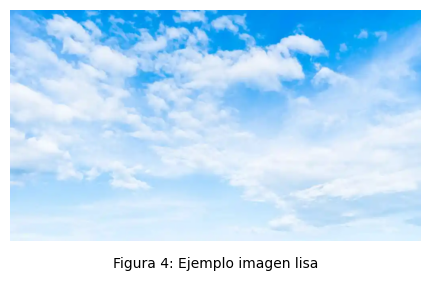

In [ ]:
# @title Imagen lisa

imagen_lisa = cv2.imread(base_path + 'Images/cielo.jpg')

plt.figure(figsize=(6,3))

plt.imshow(cv2.cvtColor(imagen_lisa, cv2.COLOR_RGB2BGR))
plt.axis('off')
plt.text(0.5, -0.1, 'Figura 4: Ejemplo imagen lisa', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

plt.show()

Text(0.5, -0.1, 'Figura 6: Relacion entre los valores')

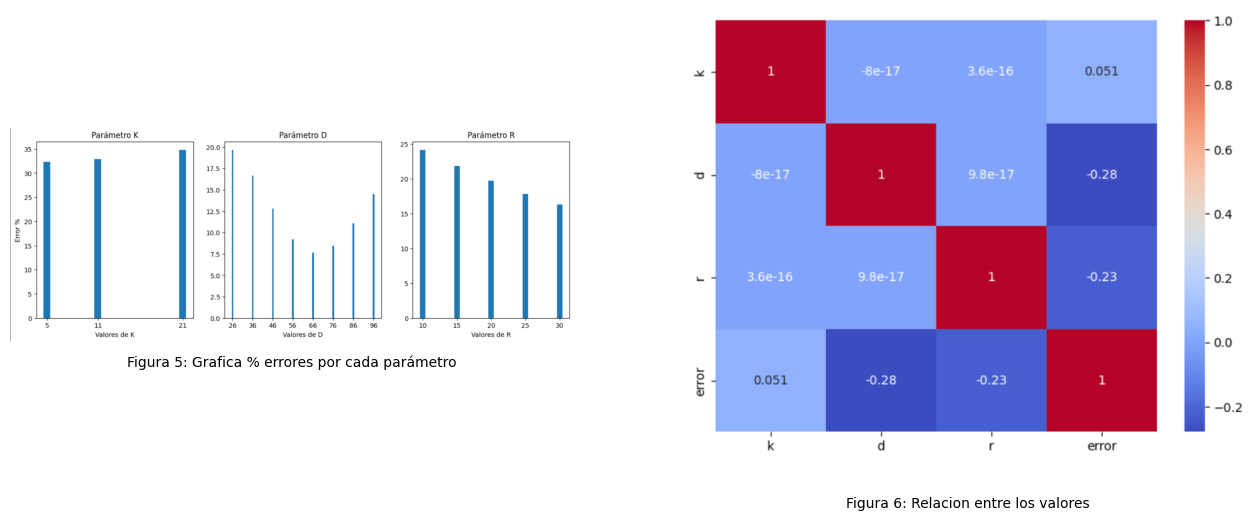

In [ ]:
# @title Análisis

analisis_lisa = cv2.imread(base_path + 'Images/analisis/analisis_lisa.png')
relacion_lisa = cv2.imread(base_path + 'Images/analisis/relacion_lisa.png')

plt.figure(figsize=(16,6))

plt.subplot(121)
plt.imshow(cv2.cvtColor(analisis_lisa, cv2.COLOR_RGB2BGR))
plt.axis('off')
plt.text(0.5, -0.1, 'Figura 5: Grafica % errores por cada parámetro', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

plt.subplot(122)
plt.imshow(cv2.cvtColor(relacion_lisa, cv2.COLOR_RGB2BGR))
plt.axis('off')
plt.text(0.5, -0.1, 'Figura 6: Relacion entre los valores', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)


<ipython-input-29-788b1d9e3aa7>:31: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  structural_image = denoise_tv_chambolle(image_float, weight=tv_weight, multichannel=True)


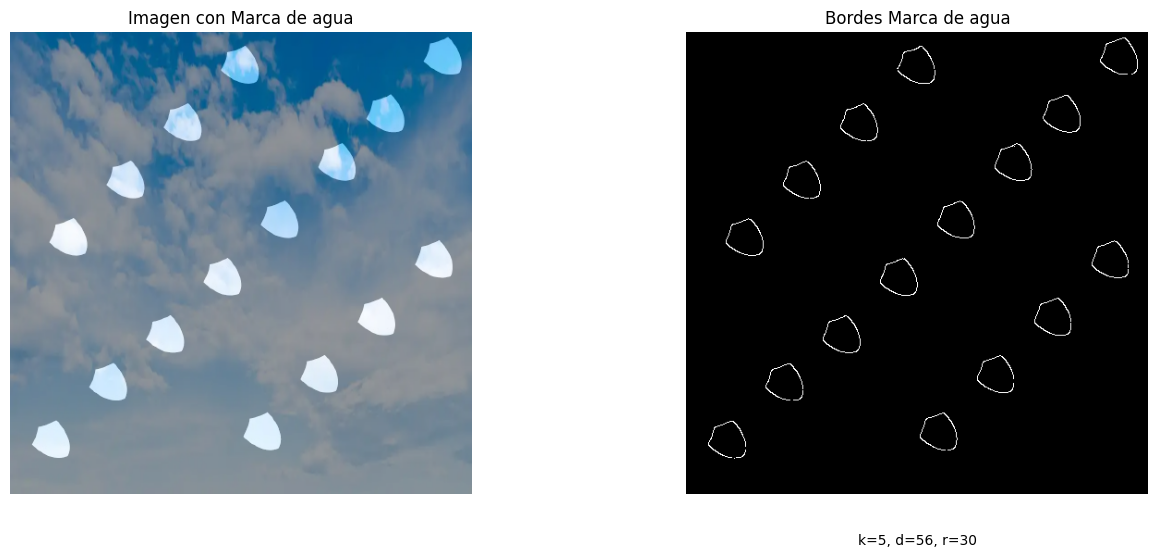

In [ ]:
# @title Detectar marca de agua lisa

watermark_edges = detect_and_classify_watermark(base_path + 'Images/analisis/lisa_wm.png', 5, 56,30)

image_watermarket = cv2.imread(base_path + 'Images/analisis/lisa_wm.png')

plt.figure(figsize=(16,6))
plt.subplot(121), plt.title('Imagen con Marca de agua'), plt.imshow(cv2.cvtColor(image_watermarket, cv2.COLOR_RGB2BGR), cmap='gray'), plt.axis('off')
plt.subplot(122), plt.title('Bordes Marca de agua'), plt.imshow(watermark_edges, cmap='gray'), plt.axis('off')
plt.text(0.5, -0.1, 'k=5, d=56, r=30', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

plt.show()

#### Patrones

Para las imágenes con patrones (Figura 7), se observa que un **kernel bajo** produce mejores resultados, mientras que una **distancia alta** (entre 86 y 96) reduce considerablemente el error. Dado que se trata de imágenes con patrones, donde los bordes están cercanos entre sí, es necesario aumentar la distancia para evitar conservar bordes muy próximos. Por otro lado, el cambio en $r$ no genera una gran diferencia, pero aún así, un **rango bajo** minimizaría los errores. (Figura 9).

Se evidencia que, en el caso de imágenes con patrones, el valor de $d$ es el factor más crucial al ejecutar el algoritmo. Se reitera la importancia de establecer una distancia considerable entre los bordes al clasificarlos, dado que se trata de imágenes con múltiples bordes cercanos entre sí. Figura 10.

> No obstante, estos resultados analíticos no funcionan bien para todas las imágenes, en función de las características de la misma podría funcionar mejor otra configuración en los valores de los parámetros. Esta es una representación de los resultados obtenidos en el estudio.

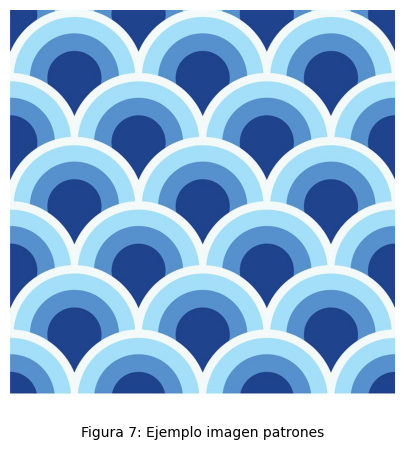

In [ ]:
# @title Imagen patrones

imagen_patrones = cv2.imread(base_path + 'Images/tipos/patrones/3.jpg')

plt.figure(figsize=(8,5))

plt.imshow(cv2.cvtColor(imagen_patrones, cv2.COLOR_RGB2BGR))
plt.axis('off')
plt.text(0.5, -0.1, 'Figura 7: Ejemplo imagen patrones', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

plt.show()

Text(0.5, -0.1, 'Figura 10: Relacion entre los valores')

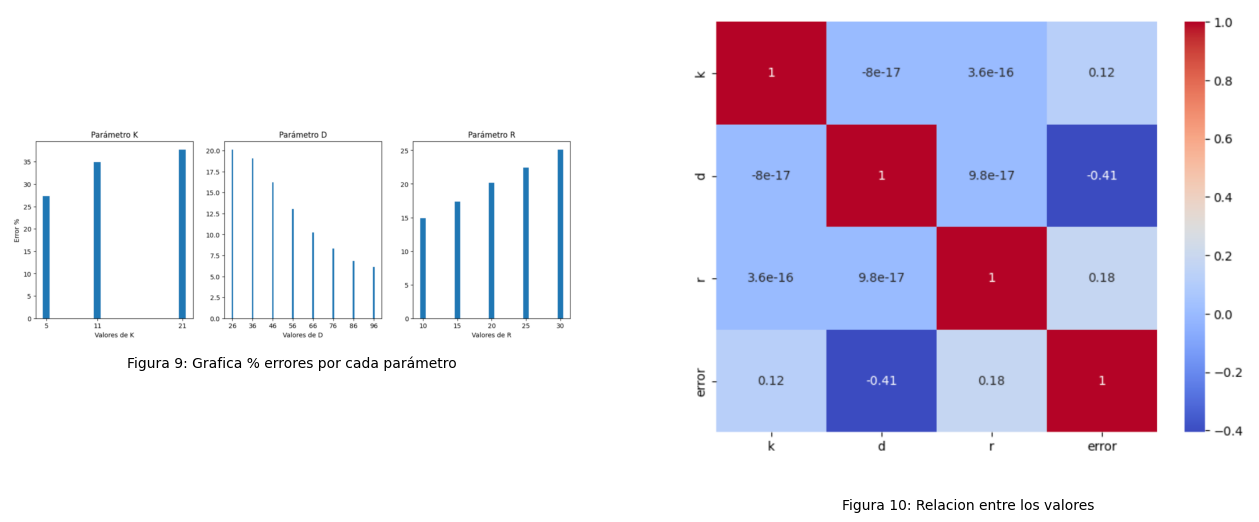

In [ ]:
# @title Análisis

analisis_patron = cv2.imread(base_path + 'Images/analisis/analisis_patron.png')
relacion_patron = cv2.imread(base_path + 'Images/analisis/relacion_patron.png')

plt.figure(figsize=(16,6))

plt.subplot(121)
plt.imshow(cv2.cvtColor(analisis_patron, cv2.COLOR_RGB2BGR))
plt.axis('off')
plt.text(0.5, -0.1, 'Figura 9: Grafica % errores por cada parámetro', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

plt.subplot(122)
plt.imshow(cv2.cvtColor(relacion_patron, cv2.COLOR_RGB2BGR))
plt.axis('off')
plt.text(0.5, -0.1, 'Figura 10: Relacion entre los valores', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)


<ipython-input-29-788b1d9e3aa7>:31: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  structural_image = denoise_tv_chambolle(image_float, weight=tv_weight, multichannel=True)


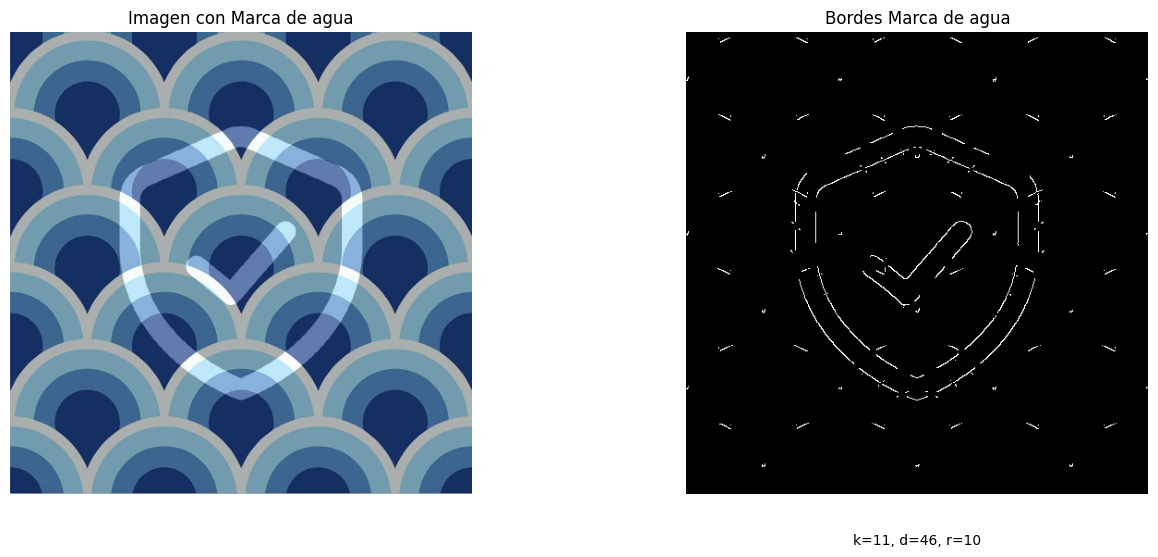

In [ ]:
# @title Detectar marca de agua patrones

watermark_edges = detect_and_classify_watermark(base_path + 'Images/analisis/patron_wm.png',11, 46,10)

image_watermarket = cv2.imread(base_path + 'Images/analisis/patron_wm.png')

plt.figure(figsize=(16,6))
plt.subplot(121), plt.title('Imagen con Marca de agua'), plt.imshow(cv2.cvtColor(image_watermarket, cv2.COLOR_RGB2BGR), cmap='gray'), plt.axis('off')
plt.subplot(122), plt.title('Bordes Marca de agua'), plt.imshow(watermark_edges, cmap='gray'), plt.axis('off')
plt.text(0.5, -0.1, 'k=11, d=46, r=10', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

plt.show()

#### Detalladas

Para imágenes altamente detalladas como la Figura 11, nuevamente se observa que un **kernel pequeño** es altamente beneficioso, junto con un **rango de tolerancia reducido**, aunque los cambios en estas variables no generan grandes variaciones en el error. Por otro lado, dado que las imágenes detalladas son más complejas, los valores de $d$ presentan un rango muy amplio, y su elección dependerá en gran medida de la imagen específica que se esté utilizando. Sin embargo, en general, sería conveniente emplear una **distancia media** entre 66 y 86. (Figura 11)

Por lo tanto, al igual que en los tipos anteriores, podemos observar que el parámetro de distancia es el factor determinante más significativo en relación con el error, y aumentar este parámetro tiende a reducir el error. (Figura 12)

> No obstante, estos resultados analíticos no funcionan bien para todas las imágenes, en función de las características de la misma podría funcionar mejor otra configuración en los valores de los parámetros. Esta es una representación de los resultados obtenidos en el estudio.

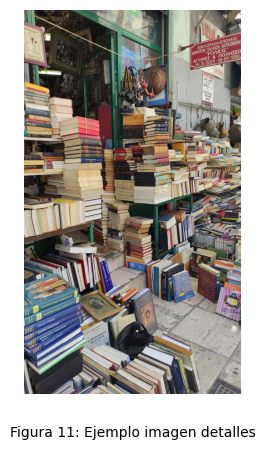

In [ ]:
# @title Imagen detallada

imagen_detalle = cv2.imread(base_path + 'Images/tipos/detalle/4.jpg')

plt.figure(figsize=(8,5))

plt.imshow(cv2.cvtColor(imagen_detalle, cv2.COLOR_RGB2BGR))
plt.axis('off')
plt.text(0.5, -0.1, 'Figura 11: Ejemplo imagen detalles', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

plt.show()

Text(0.5, -0.1, 'Figura 13: Relacion entre los valores')

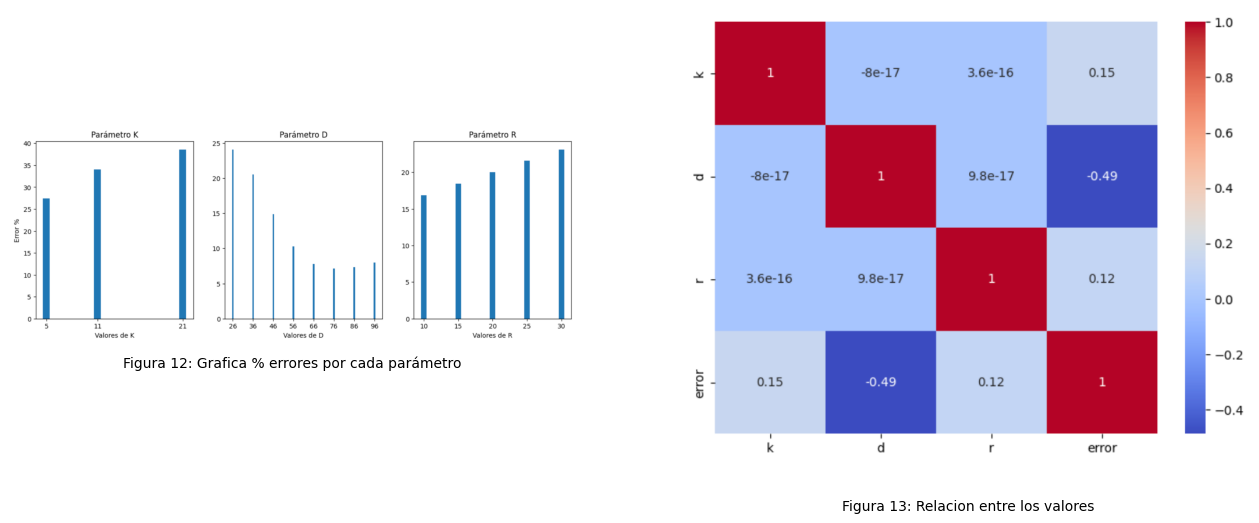

In [ ]:
# @title Análisis

analisis_detalle= cv2.imread(base_path + 'Images/analisis/analisis_detalle.png')
relacion_detalle = cv2.imread(base_path + 'Images/analisis/relacion_detalle.png')

plt.figure(figsize=(16,6))

plt.subplot(121)
plt.imshow(cv2.cvtColor(analisis_detalle, cv2.COLOR_RGB2BGR))
plt.axis('off')
plt.text(0.5, -0.1, 'Figura 12: Grafica % errores por cada parámetro', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

plt.subplot(122)
plt.imshow(cv2.cvtColor(relacion_detalle, cv2.COLOR_RGB2BGR))
plt.axis('off')
plt.text(0.5, -0.1, 'Figura 13: Relacion entre los valores', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)


<ipython-input-29-788b1d9e3aa7>:31: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  structural_image = denoise_tv_chambolle(image_float, weight=tv_weight, multichannel=True)


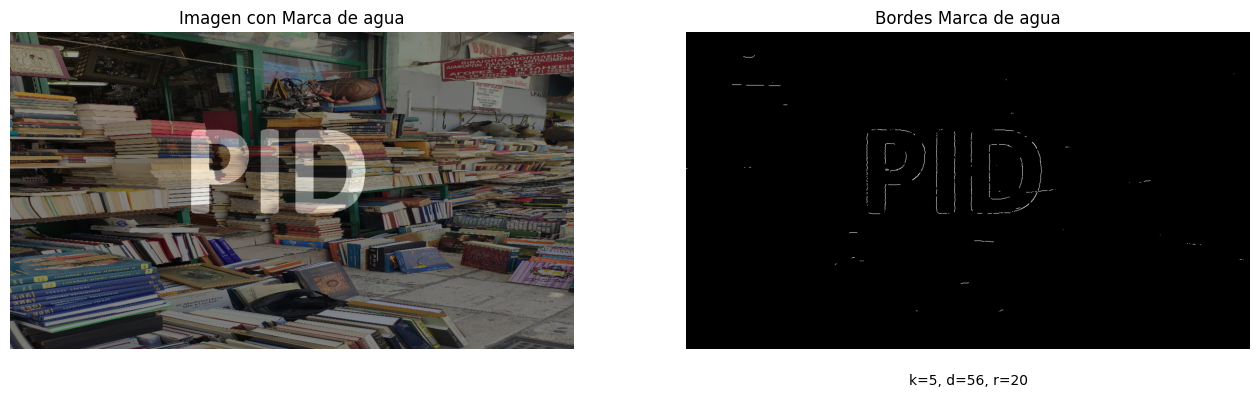

In [ ]:
# @title Detectar marca de agua imagen detallada

watermark_edges = detect_and_classify_watermark(base_path + 'Images/analisis/detalle_wm.png',5, 56,20)

image_watermarket = cv2.imread(base_path + 'Images/analisis/detalle_wm.png')

plt.figure(figsize=(16,6))
plt.subplot(121), plt.title('Imagen con Marca de agua'), plt.imshow(cv2.cvtColor(image_watermarket, cv2.COLOR_RGB2BGR), cmap='gray'), plt.axis('off')
plt.subplot(122), plt.title('Bordes Marca de agua'), plt.imshow(watermark_edges, cmap='gray'), plt.axis('off')
plt.text(0.5, -0.1, 'k=5, d=56, r=20', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

plt.show()

## Conclusión

En este trabajo, hemos implementado y evaluado el método propuesto en el artículo *An Automatic Visible Watermark Detection Method using Total Variation* elaborado por investigadores de la Universidad de México para la detección de marcas de agua en imágenes. A través de nuestra investigación, hemos validado la efectividad del algoritmo en distintos conjuntos de imágenes, observando unos buenos resultados en condiciones variadas, lo que indica una alta capacidad del método para adaptarse a diferentes tipos de contenido y perturbaciones en las imágenes.

Nuestra experimentación, se ha basado en el análisis de sensibilidad y correlación de los parámetros del método, pudiendo así detectar aquellos que son críticos e influyentes en la eficacia de la detección. De esta forma, proponemos un punto de partida a futuras investigaciones y mejoras al método. Además, hemos identificado limitaciones relacionadas con la alta complejidad computacional del algoritmo, lo que podría restringir su uso en aplicaciones en tiempo real o en dispositivos con recursos limitados. Futuras investigaciones podrían enfocarse en optimizar estos aspectos mediante el uso de heurísticas y algoritmos de decisión.

Por último, comentar que este trabajo no solo corrobora la eficacia del artículo original, sino que también amplía nuestro entendimiento en el ámbito de la detección de las marcas de agua y el procesamiento de imágenes complejas. Estas investigaciones podrían ser de gran utilidad para el desarrollo de nuevas técnicas que aborden los desafíos emergentes en la protección de la propiedad intelectual en medios digitales.

# Autoevaluación


|CRITERIOS                           |Alberto|Felix|Carmen|
|----------------------------------|-------|-----|------|
|Comprensión y dominio             |0.75   |0.65 |0.65  |
|Exposición didactica              |0.9    |1    |1     |
|Integración del equipo            |1      |1    |1     |
|Objetivos                         |0.8    |0.8  |0.8   |
|Aspectos didácticos               |0.9    |1    |1     |
|Experimentación y conclusiones    |0.8    |0.8  |1     |
|Contenidos                        |0.75   |1    |0.65  |
|Divulgación de los contenidos     |0.9    |1    |1     |
|Bibliografía. Recursos científicos|0.65   |0.65 |0.65  |


# Bibliografía


**Papers**

H. Santoyo-Garcia, E. Fragoso-Navarro, R. Reyes-Reyes, G. Sanchez-Perez, M. Nakano-Miyatake and H. Perez-Meana, "An automatic visible watermark detection method using total variation," 2017 5th International Workshop on Biometrics and Forensics (IWBF), Coventry, UK, 2017, pp. 1-5, doi: 10.1109/IWBF.2017.7935109.

A. Levin, D. Lischinski and Y. Weiss, "A Closed-Form Solution to Natural Image Matting," in IEEE Transactions on Pattern Analysis and Machine Intelligence, vol. 30, no. 2, pp. 228-242, Feb. 2008, doi: 10.1109/TPAMI.2007.1177.

Antonin Chambolle, Vicent Caselles, Matteo Novaga, Daniel Cremers, Thomas Pock. An introduction to Total Variation for Image Analysis. 2009. ⟨hal-00437581⟩

**Páginas web**

Rémi Flamary - Total variation in images (2024, 19 de Abril). https://remi.flamary.com/demos/proxtv.html

